### Model description and features
XGB model on all users that added product on July 2016,  

Features:
------------
* June 2015, user attributes
* July 2015, user attributes
* June 2015, product subscription information

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scripts.kaggle.helpers import make_submission
import datetime
from tqdm import tqdm
import gc
import itertools
from multiprocessing import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 16)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def test_train_split(df, wt_col, test_frac):
    n = int(len(df)*test_frac)
    rows = df.sample(n, weights=wt_col.apply(lambda x: wt_col.value_counts()[x])).index
    test = df.ix[rows]
    train = df.drop(rows)
    return test, train, rows

In [3]:
TRAIN_MONTH_OLD = '2015_05_28'
TRAIN_MONTH_NEW = '2015_06_28'

TEST_MONTH_OLD = '2016_05_28'
#TEST_MONTH_NEW = '2016_06_28'

TRAIN_FILE_OLD = 'data/train_' + TRAIN_MONTH_OLD + '.csv'
TRAIN_FILE_NEW = 'data/train_' + TRAIN_MONTH_NEW + '.csv'

ADDED_PRODUCTS_FILE = 'data/added_product_' + TRAIN_MONTH_OLD + '.csv'

TEST_FILE_OLD = 'data/train_' + TEST_MONTH_OLD + '.csv'
TEST_FILE_NEW = 'data/test_ver2.csv'

HEADER = ["fecha_dato", "ncodpers", "ind_empleado",
          "pais_residencia", "sexo", "age", "fecha_alta",
          "ind_nuevo", "antiguedad", "indrel", "ult_fec_cli_1t",
          "indrel_1mes", "tiprel_1mes", "indresi", "indext",
          "conyuemp", "canal_entrada", "indfall", "tipodom",
          "cod_prov", "nomprov", "ind_actividad_cliente",
          "renta", "segmento", "ind_ahor_fin_ult1",
          "ind_aval_fin_ult1", "ind_cco_fin_ult1",
          "ind_cder_fin_ult1", "ind_cno_fin_ult1",
          "ind_ctju_fin_ult1", "ind_ctma_fin_ult1",
          "ind_ctop_fin_ult1", "ind_ctpp_fin_ult1",
          "ind_deco_fin_ult1", "ind_deme_fin_ult1",
          "ind_dela_fin_ult1", "ind_ecue_fin_ult1",
          "ind_fond_fin_ult1", "ind_hip_fin_ult1",
          "ind_plan_fin_ult1", "ind_pres_fin_ult1",
          "ind_reca_fin_ult1", "ind_tjcr_fin_ult1",
          "ind_valo_fin_ult1", "ind_viv_fin_ult1",
          "ind_nomina_ult1", "ind_nom_pens_ult1",
          "ind_recibo_ult1"]

In [4]:
train_old = pd.read_csv(TRAIN_FILE_OLD, header=None, names=HEADER)
train_new = pd.read_csv(TRAIN_FILE_NEW, header=None, names=HEADER)
test_old = pd.read_csv(TEST_FILE_OLD, header=None, names=HEADER)
test_new = pd.read_csv(TEST_FILE_NEW)

added_products = pd.read_csv(ADDED_PRODUCTS_FILE)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
for col in HEADER[24:]:
    test_new[col] = [0]*test_new.shape[0]

In [6]:
combined = pd.concat((train_old, train_new, test_old, test_new)).reset_index(drop=True)

In [7]:
def process_data_from_original_dataframe(combined):
    # fixing age
    combined['age'] = pd.to_numeric(combined['age'], errors='coerce')

    combined.loc[combined.age < 18, "age"] = \
        combined.loc[(combined.age > 18) &
                     (combined.age <= 30), "age"].mean(skipna=True)
    combined.loc[combined.age > 100, "age"] = \
        combined.loc[(combined.age > 30) &
                     (combined.age <= 100), "age"].mean(skipna=True)
    combined['age'].fillna(combined['age'].mean(), inplace=True)
    combined['age'] = combined['age'].astype(int)

    # fix ind_nuevo..
    combined.loc[combined.ind_nuevo.isnull(), 'ind_nuevo'] = 1

    # fix antiguedad
    combined['antiguedad'] = pd.to_numeric(combined['antiguedad'],
                                           errors='coerce')
    combined.loc[combined.antiguedad.isnull(), 'antiguedad'] = \
        combined.antiguedad.min()
    combined.loc[combined.antiguedad < 0, 'antiguedad'] = 0

    # fix indrel
    combined.loc[combined.indrel.isnull(), 'indrel'] = 1

    # drop useless cols
    combined.drop(['tipodom', 'cod_prov'], axis=1, inplace=True)

    # fix ind_actividad_cliente
    combined.loc[combined.ind_actividad_cliente.isnull(),
                 "ind_actividad_cliente"] = \
        combined.ind_actividad_cliente.median()

    # fix city name
    combined.loc[combined.nomprov ==
                 "CORU\xc3\x91A, A", "nomprov"] = "CORUNA, A"
    combined.loc[combined.nomprov.isnull(), 'nomprov'] = 'UNKNOWN'

    # fix incomes
    # combined.renta = pd.to_numeric(combined.renta, errors='coerce')
    combined['renta'] = pd.to_numeric(combined['renta'], errors='coerce')

    grouped = combined.groupby('nomprov').\
        agg({'renta': lambda x: x.median(skipna=True)}).reset_index()
    new_incomes = pd.merge(combined, grouped,
                           how='inner',
                           on='nomprov').loc[:, ['nomprov', 'renta_y']]

    new_incomes = new_incomes.\
        rename(columns={"renta_y": "renta"}).\
        sort_values("renta").sort_values("nomprov")

    combined.sort_values("nomprov", inplace=True)
    combined = combined.reset_index()
    new_incomes = new_incomes.reset_index()
    combined.loc[combined.renta.isnull(), "renta"] = \
        new_incomes.loc[combined.renta.isnull(), "renta"].median()
    combined.sort_values(by='fecha_dato', inplace=True)

    # rest of the columns
    string_data = combined.select_dtypes(include=["object"])
    missing_columns = [col for col in string_data
                       if string_data[col].isnull().any()]
    del string_data

    combined.loc[combined.indfall.isnull(), 'indfall'] = 'N'
    combined.loc[combined.tiprel_1mes.isnull(), 'tiprel_1mes'] = 'A'
    combined.tiprel_1mes = combined.tiprel_1mes.astype('category')

    map_dict = {
        '1.0': '1',
        '1': '1',
        '3.0': '3',
        'P': 'P',
        3.0: '3',
        2.0: '2',
        '3': '3',
        '2.0': '2',
        '4.0': '4',
        '4': '4',
        '2': '2',
        1.0: '1',
        4.0: '4'
    }

    combined.indrel_1mes.fillna('P', inplace=True)
    combined.indrel_1mes = combined.indrel_1mes.apply(lambda x: map_dict[x])
    combined.indrel_1mes = combined.indrel_1mes.astype('category')

    unknown_cols = [col for col in missing_columns if
                    col not in ['indfall', 'tiprel_1mes', 'indrel_1mes']]
    for col in unknown_cols:
        combined.loc[combined[col].isnull(), col] = "UNKNOWN"

    # feature cols
    feature_cols = combined.iloc[:1, ].filter(regex="ind_+.*ult.*").\
        columns.values
    for col in feature_cols:
        combined.loc[combined[col].isnull(), col] = 0
        combined[col] = combined[col].astype(int)

    del combined['ult_fec_cli_1t'], combined['fecha_alta']

    encoders = []
    for col in ['sexo', 'indrel_1mes', 'pais_residencia', 'ind_empleado',
                'segmento', 'tiprel_1mes', 'indresi', 'indext', 'conyuemp',
                'canal_entrada', 'indfall', 'nomprov']:
        temp_enc = LabelEncoder()
        temp_enc.fit(combined[col])
        combined[col] = temp_enc.transform(combined[col])
        encoders.append(temp_enc)
    return combined, encoders



In [8]:
combined, encoders = process_data_from_original_dataframe(combined)

In [9]:
train_old = combined.loc[combined.fecha_dato == '2015-05-28', :].reset_index(drop=True)
train_new = combined.loc[combined.fecha_dato == '2015-06-28', :].reset_index(drop=True)
test_old = combined.loc[combined.fecha_dato == '2016-05-28', :].reset_index(drop=True)
test_new = combined.loc[combined.fecha_dato == '2016-06-28', :].reset_index(drop=True)

In [10]:
del train_old['index'], train_new['index'], test_old['index'], test_new['index']
del train_old['fecha_dato'], train_new['fecha_dato'], test_old['fecha_dato'], test_new['fecha_dato']

In [11]:
print train_old.shape
print train_new.shape
print test_old.shape
print test_new.shape

(631957, 43)
(632110, 43)
(931453, 43)
(929615, 43)


In [12]:
train_old.set_index('ncodpers', inplace=True)
train_new.set_index('ncodpers', inplace=True)
test_old.set_index('ncodpers', inplace=True)
test_new.set_index('ncodpers', inplace=True)

In [15]:
# added_products.set_index('ncodpers', inplace=True)
print added_products.shape
added_products.head()

(41745, 1)


,added_product
ncodpers,
15892,ind_cco_fin_ult1
15897,ind_nom_pens_ult1
15906,ind_nom_pens_ult1
15925,ind_recibo_ult1
15927,ind_cco_fin_ult1


In [16]:
train_new.columns

Index([u'ind_empleado', u'pais_residencia', u'sexo', u'age', u'ind_nuevo',
       u'antiguedad', u'indrel', u'indrel_1mes', u'tiprel_1mes', u'indresi',
       u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'nomprov',
       u'ind_actividad_cliente', u'renta', u'segmento', u'ind_ahor_fin_ult1',
       u'ind_aval_fin_ult1', u'ind_cco_fin_ult1', u'ind_cder_fin_ult1',
       u'ind_cno_fin_ult1', u'ind_ctju_fin_ult1', u'ind_ctma_fin_ult1',
       u'ind_ctop_fin_ult1', u'ind_ctpp_fin_ult1', u'ind_deco_fin_ult1',
       u'ind_deme_fin_ult1', u'ind_dela_fin_ult1', u'ind_ecue_fin_ult1',
       u'ind_fond_fin_ult1', u'ind_hip_fin_ult1', u'ind_plan_fin_ult1',
       u'ind_pres_fin_ult1', u'ind_reca_fin_ult1', u'ind_tjcr_fin_ult1',
       u'ind_valo_fin_ult1', u'ind_viv_fin_ult1', u'ind_nomina_ult1',
       u'ind_nom_pens_ult1', u'ind_recibo_ult1'],
      dtype='object')

In [27]:
# just create 1 month old lag features from the past month
train = pd.DataFrame()
test = pd.DataFrame()
test['ncodpers'] = test_new.index
train['ncodpers'] = added_products.index
test.set_index('ncodpers', inplace=True)
train.set_index('ncodpers', inplace=True)
for col in train_old.columns:
    train['old_' + col] = train_old.loc[added_products.index, col]
    test['old_' + col] = test_old.loc[test_new.index, col]

In [33]:
for col in train_old.columns[:18]:
    train['current_' + col] = train_new.loc[added_products.index, col]
    test['current_' + col] = test_new.loc[:, col]

In [34]:
label_encoder = LabelEncoder()
label_encoder.fit(added_products.added_product)
added_products['encoded_products'] = label_encoder.\
    transform(added_products['added_product'])

In [37]:
print test.shape
print train.shape

(929615, 60)
(41745, 60)


In [38]:
xgb_main = xgb.DMatrix(train, label=added_products.encoded_products)

In [39]:
def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

In [40]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 100
plist = param.items()

evallist = [(xgb_main, 'train')]

In [41]:
xgb_model = xgb.train(plist, xgb_main, num_rounds, evallist, feval=map7eval)

[0]	train-MAP@7:0.691604
[1]	train-MAP@7:0.696586
[2]	train-MAP@7:0.701306
[3]	train-MAP@7:0.703054
[4]	train-MAP@7:0.70339
[5]	train-MAP@7:0.703893
[6]	train-MAP@7:0.704803
[7]	train-MAP@7:0.705186
[8]	train-MAP@7:0.705761
[9]	train-MAP@7:0.706624
[10]	train-MAP@7:0.706648
[11]	train-MAP@7:0.706815
[12]	train-MAP@7:0.707079
[13]	train-MAP@7:0.707462
[14]	train-MAP@7:0.707725
[15]	train-MAP@7:0.708085
[16]	train-MAP@7:0.708133
[17]	train-MAP@7:0.708444
[18]	train-MAP@7:0.70866
[19]	train-MAP@7:0.709091
[20]	train-MAP@7:0.709354
[21]	train-MAP@7:0.709618
[22]	train-MAP@7:0.709666
[23]	train-MAP@7:0.709905
[24]	train-MAP@7:0.710073
[25]	train-MAP@7:0.710408
[26]	train-MAP@7:0.71048
[27]	train-MAP@7:0.71072
[28]	train-MAP@7:0.710888
[29]	train-MAP@7:0.711007
[30]	train-MAP@7:0.711151
[31]	train-MAP@7:0.711199
[32]	train-MAP@7:0.711486
[33]	train-MAP@7:0.711486
[34]	train-MAP@7:0.711654
[35]	train-MAP@7:0.711798
[36]	train-MAP@7:0.712061
[37]	train-MAP@7:0.712253
[38]	train-MAP@7:0.712373


In [42]:
del combined, test_old, test_new, train_old, train_new
gc.collect()

1498

In [44]:
test.head()

,old_ind_empleado,old_pais_residencia,old_sexo,old_age,old_ind_nuevo,old_antiguedad,old_indrel,old_indrel_1mes,old_tiprel_1mes,old_indresi,...,current_indext,current_conyuemp,current_canal_entrada,current_indfall,current_nomprov,current_ind_actividad_cliente,current_renta,current_segmento,xgb_preds,added_products
ncodpers,,,,,,,,,,,,,,,,,,,,,
441607,3,36,2,59,0.0,151.0,1.0,0,1,1,...,0,2,10,0,43,0.0,113217.78,1,ind_cco_fin_ult1 ind_ctop_fin_ult1 ind_recibo_...,ind_recibo_ult1
70507,3,36,2,63,0.0,225.0,1.0,0,0,1,...,0,2,24,0,8,1.0,147590.25,1,ind_tjcr_fin_ult1 ind_reca_fin_ult1 ind_ecue_f...,ind_recibo_ult1
1115883,3,36,2,35,0.0,40.0,1.0,0,1,1,...,0,2,122,0,41,1.0,145177.71,1,ind_cco_fin_ult1 ind_cno_fin_ult1 ind_nom_pens...,ind_recibo_ult1
59103,3,36,2,51,0.0,230.0,1.0,0,1,1,...,0,2,24,0,8,0.0,111447.18,1,ind_recibo_ult1 ind_tjcr_fin_ult1 ind_reca_fin...,ind_recibo_ult1
444815,3,36,2,50,0.0,150.0,1.0,0,0,1,...,0,2,118,0,12,1.0,78892.26,1,ind_recibo_ult1 ind_tjcr_fin_ult1 ind_dela_fin...,ind_recibo_ult1


In [45]:
final_test = xgb.DMatrix(test)
preds = xgb_model.predict(final_test)
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'old_ind_ahor_fin_ult1':'old_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [14:23<00:00, 1075.97it/s]


In [47]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/submissions/7.xgb_trained_on_jun_2015_only_added_users_1_month_lag_features.csv'
description = '7. xgb model trained on june 2015 on added products and more features\
               and one month old lag features of all columns and current month user attributes:\n' + str(param)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True)

Compressing file
Compression done
Uploading submission data/submissions/7.xgb_trained_on_jun_2015_only_added_users_1_month_lag_features.csv.zip
Upload done


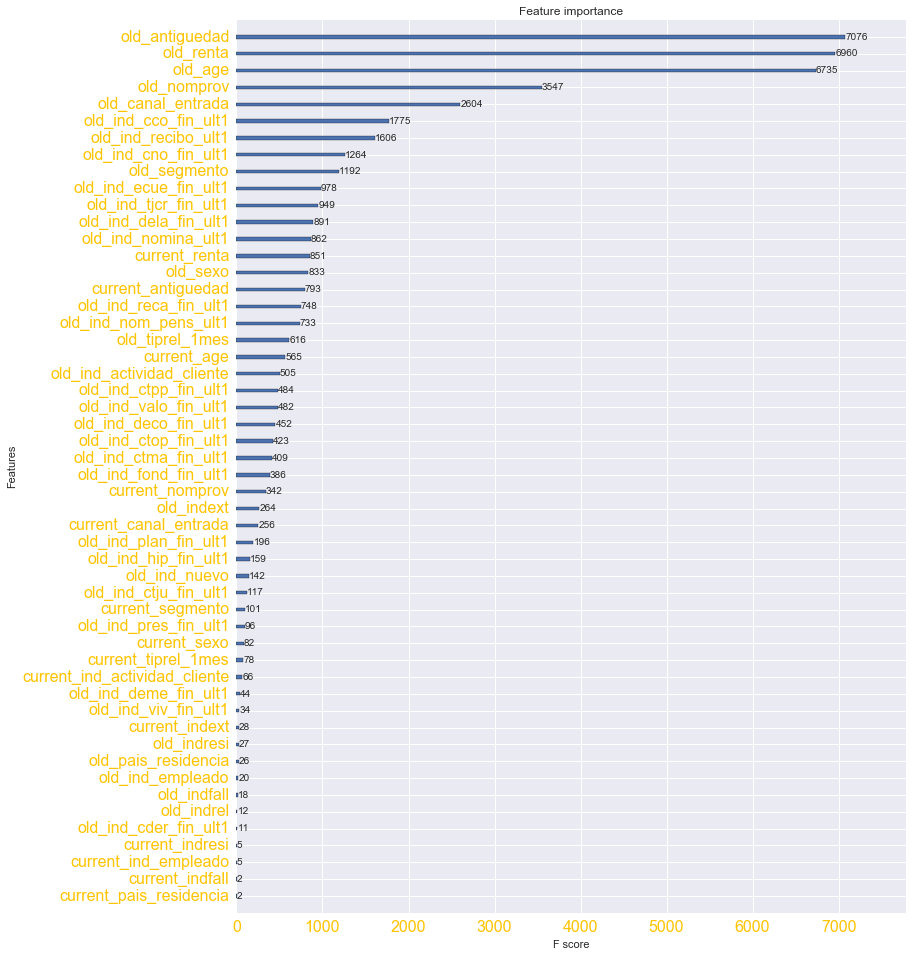

In [48]:
xgb.plot_importance(xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=16, labelcolor="#ffc400")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))